<a href="https://colab.research.google.com/github/EmmaCOo/Assignment_5.1-Topic_Modeling/blob/main/ADS509_Assignment_5_1_Topic_Modeling_Emma_Oo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**ADS 509_Assignment 5.1: Topic Modeling**

###**Emma Oo**

09/30/2022

his notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required.

In this assignment you will work with a categorical corpus that accompanies nltk. You will build the three types of topic models described in Chapter 8 of Blueprints for Text Analytics using Python: NMF, LSA, and LDA. You will compare these models to the true categories.

Instruction Github link: 

https://github.com/37chandler/ads-tm-topic-modeling/blob/main/Topic%20Modeling.ipynb



In [39]:
#!pip install pyLDAvis

In [2]:
# These libraries may be useful to you

from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

#import gensim
#import gensim.corpora as corpora
#from gensim.utils import simple_preprocess
#from gensim.models import CoherenceModel,LdaMulticore, Phrases 
#from gensim.models.phrases import Phraser 
#from gensim.corpora import Dictionary

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

import warnings #turn off warnings
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)  

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [3]:
# add any additional libaries you need here
import nltk
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [4]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

###**Getting to Know the Brown Corpus**

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [5]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.


In [6]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [7]:
df.head()

,category,id,text
0,editorial,cb01,Assembly session brought much good The General...
1,editorial,cb02,Must Berlin remain divided ? ? The inference h...
2,editorial,cb03,"A good man departs . Goodby , Mr. Sam . Sam Ra..."
3,editorial,cb04,A shock wave from Africa Word of Dag Hammarskj...
4,editorial,cb05,Help when needed If the Dominican Republic ach...


In [8]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)   #length of character
df['word_len'] = df['text'].apply(lambda x: len(x.split()))  #length of words after splitting the text

In [9]:
df.head()

,category,id,text,char_len,word_len
0,editorial,cb01,Assembly session brought much good The General...,12659,2200
1,editorial,cb02,Must Berlin remain divided ? ? The inference h...,12544,2234
2,editorial,cb03,"A good man departs . Goodby , Mr. Sam . Sam Ra...",11871,2244
3,editorial,cb04,A shock wave from Africa Word of Dag Hammarskj...,12284,2230
4,editorial,cb05,Help when needed If the Dominican Republic ach...,12479,2241


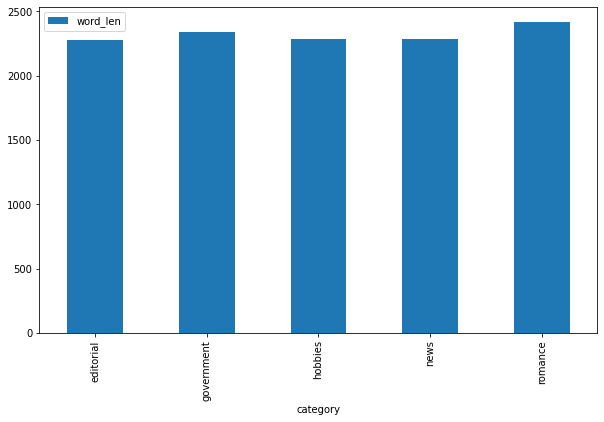

In [10]:
%matplotlib inline
#visualize the cateogry group with the average word_len
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [11]:
 #Countvectorizer without word counts less than 5 and more than 70%
count_text_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7) 
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

(166, 4941)

In [12]:
#TF-IDF (same parameters as CountVectorizer)
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

In [13]:
print(count_text_vectors[:,60])

  (27, 0)	1
  (46, 0)	1
  (53, 0)	1
  (66, 0)	1
  (139, 0)	1
  (156, 0)	2


In [14]:
print(tfidf_text_vectors[:,60])

  (27, 0)	0.01764473395704825
  (46, 0)	0.016783312419191787
  (53, 0)	0.025232554436808993
  (66, 0)	0.031999822461509696
  (139, 0)	0.02638584089033688
  (156, 0)	0.023873060675386706


Q: What do the two data frames count_text_vectors and tfidf_text_vectors hold?

**A:  Count_text_vectors hold only the counts of the vectorized tokens while tfidf_text_vectors hold the frequency of the vectorized tokens.**

###**Fitting a Non-Negative Matrix Factorization Model**

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the BTAP repo, which will help you tremendously in the coming sections.

In [15]:
nmf_text_model = NMF(n_components=5, random_state=314)  #n_components =5 for five_topic to be detected by NMF
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [16]:
#summary of the topics that NMF detected in the text 
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.40)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.64)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.01)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results.

In [17]:
#Distribution of Each Category for Original Brown Corpus
df['category'].value_counts(normalize=True)*100

news          26.506024
hobbies       21.686747
government    18.072289
romance       17.469880
editorial     16.265060
Name: category, dtype: float64

In [18]:
#copy orginal dataframe
nmf_df = df.copy()
nmf_df.head(2)

,category,id,text,char_len,word_len
0,editorial,cb01,Assembly session brought much good The General...,12659,2200
1,editorial,cb02,Must Berlin remain divided ? ? The inference h...,12544,2234


In [19]:
# use idxmax to return the index of the row with the highest occurence of NMF topic model words
nmf_df['NMF_Topics'] = pd.DataFrame(W_text_matrix).idxmax(axis=1)   #axis=1 for rows
nmf_df.head()

,category,id,text,char_len,word_len,NMF_Topics
0,editorial,cb01,Assembly session brought much good The General...,12659,2200,2
1,editorial,cb02,Must Berlin remain divided ? ? The inference h...,12544,2234,0
2,editorial,cb03,"A good man departs . Goodby , Mr. Sam . Sam Ra...",11871,2244,0
3,editorial,cb04,A shock wave from Africa Word of Dag Hammarskj...,12284,2230,0
4,editorial,cb05,Help when needed If the Dominican Republic ach...,12479,2241,0


In [20]:
#Group by category and NMF_topics
group_df = pd.DataFrame(nmf_df.groupby(['NMF_Topics','category']).count())
group_df
#drop extra column such as 'id', 'char_len', 'word_len'
group_df.drop(columns = ['id','char_len','word_len'])

text
NMF_Topics category        
0          editorial     20
           government     4
           news           8
1          editorial      4
           hobbies        8
           romance       29
2          editorial      2
           government    26
           hobbies       26
           news          11
3          hobbies        1
           news          17
4          editorial      1
           hobbies        1
           news           8

In [21]:
#Overall total count of all topic models per category
sort = group_df.groupby(['category']).sum()
sort.sort_values('text', ascending=False)

,id,text,char_len,word_len
category,,,,
news,44,44,44,44
hobbies,36,36,36,36
government,30,30,30,30
romance,29,29,29,29
editorial,27,27,27,27


Q: How does your five-topic NMF model compare to the original Brown categories?

**A: The highest category from topic 0 is editorial (20), topic 1 is romance (29), topic 2 is government and hobbies tied (26), topic 3 is news (17), and topic 4 is news (8). Looking at each topic model separately, topic 2 includes almost all types of categories except romance category like in the original Brown corpus.**

**For overall combined counts of all topic models, the order of the topic models rank from news, hobbies, government, romance, editorial category.  They rank the same as the original Bronwn corpus categories.** 

###**Fitting an LSA Model**

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in sklearn). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above.

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results.

In [22]:
from sklearn.decomposition import TruncatedSVD

svd_para_model = TruncatedSVD(n_components = 5, random_state=42)
W_svd_para_matrix = svd_para_model.fit_transform(tfidf_text_vectors)
H_svd_para_matrix = svd_para_model.components_

#display 5 topic models
display_topics(svd_para_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.14)
  mr (1.73)
  said (1.05)
  kennedy (0.81)
  president (0.77)

Topic 03
  mrs (30.38)
  club (6.70)
  game (6.40)
  jr (5.81)
  dallas (5.50)

Topic 04
  game (4.33)
  league (3.09)
  baseball (3.06)
  ball (2.94)
  team (2.81)


In [23]:
#copy df and save under lsa_df
lsa_df = df.copy()

# use idxmax to return the index of the row with the highest occurence of LSA topic model words
lsa_df['LSA_Topics'] = pd.DataFrame(W_svd_para_matrix).idxmax(axis=1)   #axis=1 for rows

#Group by category and NMF_topics
lsa_group_df = pd.DataFrame(lsa_df.groupby(['LSA_Topics','category']).count())

#drop extra column such as 'id', 'char_len', 'word_len'
lsa_group_df.drop(columns = ['id','char_len','word_len'])

text
LSA_Topics category        
0          editorial     27
           government    30
           hobbies       36
           news          34
           romance       21
1          romance        8
3          news           3
4          news           7

In [24]:
#Overall total count of all topic models per category
lsa_sort = lsa_group_df.groupby(['category']).sum()
lsa_sort.sort_values('text', ascending=False)

,id,text,char_len,word_len
category,,,,
news,44,44,44,44
hobbies,36,36,36,36
government,30,30,30,30
romance,29,29,29,29
editorial,27,27,27,27


Q: How does your five-topic LSA model compare to the original Brown categories?

**A: It's interesting to see the higher tally counts for topic 0 while there's no count for topic 2.  Since topic 0 and 1 shared most words such as 'said', 'mr', and 'mrs', it's possible that all the words from both topics are counted under the topic 0. Topic 0 includes all types of categories like the orginal Brown corpus.**

**For total counts, the orders are news, hobbies, government, romance, and editorial and follow the same as the original Brown corpus categories.**


Q: What is your interpretation of the display topics output?

**A:  Display topics output inform the words found in each topic and their percentage distribution to the topics. From LSA topic models, 'mrs' contributes the most with 30.38% while 'man' is the least with only 0.17%.**

###**Fitting an LDA Model**

Finally, fit a five-topic LDA model using the count vectors (count_text_vectors from above).

Display the results using pyLDAvis.display and describe what you learn from that visualization.

In [25]:
from sklearn.decomposition import LatentDirichletAllocation

lda_text_model = LatentDirichletAllocation(n_components = 5, random_state=42)
W_lda_para_matrix = lda_text_model.fit_transform(count_text_vectors)
H_lda_para_matrix = lda_text_model.components_

display_topics(lda_text_model, count_text_vectorizer.get_feature_names())


Topic 00
  home (0.46)
  right (0.35)
  game (0.35)
  way (0.34)
  set (0.34)

Topic 01
  state (0.89)
  development (0.57)
  states (0.51)
  program (0.46)
  use (0.44)

Topic 02
  said (0.93)
  mr (0.73)
  president (0.63)
  state (0.49)
  mrs (0.48)

Topic 03
  feed (0.90)
  general (0.73)
  business (0.70)
  property (0.69)
  shall (0.67)

Topic 04
  said (1.56)
  man (0.62)
  little (0.62)
  old (0.59)
  good (0.53)


In [26]:
#copy df and save under lda_df
lda_df = df.copy()

# use idxmax to return the index of the row with the highest occurence of LSA topic model words
lda_df['LDA_Topics'] = pd.DataFrame(W_lda_para_matrix).idxmax(axis=1)   #axis=1 for rows

#Group by category and NMF_topics
lda_group_df = pd.DataFrame(lda_df.groupby(['LDA_Topics','category']).count())

#drop extra column such as 'id', 'char_len', 'word_len'
lda_group_df.drop(columns = ['id','char_len','word_len'])

text
LDA_Topics category        
0          editorial      3
           hobbies       16
           news           9
1          editorial      1
           government    20
           hobbies       14
           news           3
2          editorial     22
           government     2
           hobbies        1
           news          31
3          government     8
           hobbies        3
           news           1
4          editorial      1
           hobbies        2
           romance       29

In [27]:
#Overall total count of all topic models per category
lda_sort = lda_group_df.groupby(['category']).sum()
lda_sort.sort_values('text', ascending=False)

,id,text,char_len,word_len
category,,,,
news,44,44,44,44
hobbies,36,36,36,36
government,30,30,30,30
romance,29,29,29,29
editorial,27,27,27,27


Q: What inference do you draw from the displayed topics for your LDA model?

**A: The words from each topic model by LDA is more significant and specific than other topic models. For example, topic 0 can be estimated that it probably belongs to news while topic 1 can be estimated as government, etc.Topic 1 and 2 includes 4 categories.**

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories?

**A:  The total count follow the same as the original Brown Corpus categories.**


In [28]:
lda_display = pyLDAvis.sklearn.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [29]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

**A:  By the principal component scatterplots, topic 1 and 5 have perfect separations and hold the most unique words.  There's a few overlap between topic 3 and 2.  Topic 4 overlap mostly with topic 2. Thus the words from topic 1 and 5 are unique words, some overlapping words between topic 3 and 2 while topic 4 shares majority of its words with topic 2. Among them, the unique words from topic 1 and 5 can be used as a training set for the supervised learning.**

**The salient terms graph represents the estimated term frequency within the selected topic and overall term frequency. Topic 3 and 5 seem pronounced since their length of the bars are decreasing quickly while topic 1, 2, and 4 are not. When hover over the words of topic 4 in the salient graph, the hovered words will show the distribution between the overlapped topic 2 and 4.**

In [40]:
!jupyter nbconvert --to html /content/ADS509_Assignment_5_1_Topic_Modeling_Emma_Oo.ipynb

[NbConvertApp] Converting notebook /content/ADS509_Assignment_5_1_Topic_Modeling_Emma_Oo.ipynb to html
[NbConvertApp] Writing 443645 bytes to /content/ADS509_Assignment_5_1_Topic_Modeling_Emma_Oo.html
